## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
sample_names = "pre,post"
outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_btwncond_ATAC/minPct_0_logfc0.1"

# Parameters
assay="ATAC"
minPct = 0.00
logfcthresh = 0.1
top_de = 3
p_thresh=0.1
test.use="LR"
latent.vars = "peak_region_fragments"

# Parallel processing
cores = 12

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"



In [2]:
source(utils_script)
outdir = outdir
dir.create(outdir, showWarnings = FALSE)

btwnConds_inClust_sepDonrs.outdir <- file.path(outdir, "btwnConds_inClust_sepDonrs")
dir.create(btwnConds_inClust_sepDonrs.outdir)

btwnConds_inClust.outdir <- file.path(outdir, "btwnConds_inClust")
dir.create(btwnConds_inClust.outdir, showWarnings = FALSE)

Attaching SeuratObject

Warning message in dir.create(btwnConds_inClust_sepDonrs.outdir):
“'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_btwncond_ATAC/minPct_0_logfc0.1/btwnConds_inClust_sepDonrs' already exists”


In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "pre"  "post"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Lo

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
DefaultAssay(se) <- assay
se

An object of class Seurat 
97805 features across 22239 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap

# Stimulus specific response in each cluster 

## Stimulus specific response in each cluster, not splitting donors

In [6]:

source(utils_script)

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

#sample_names
cluster.ids <- sort(unique(se$seurat_clusters))
se$celltype.stim <- paste(se$seurat_clusters, se$orig.ident, sep = "_")
se$celltype <- se$seurat_clusters
Idents(se) <- "celltype.stim"

for (curr.clust in cluster.ids){
    ident.1 = paste0(curr.clust, "_", sample_names[[1]]) 
    ident.2 = paste0(curr.clust, "_", sample_names[[2]])
    try({
        print(curr.clust)
        #se.filt <- subset(se, idents = c(ident.1,ident.2))
        #curr.donor = se.filt$donor[[1]] #strsplit(c,"_")[[2]]
        curr.name <-paste0("clust_", curr.clust)
        curr.clust.outdir <- file.path(btwnConds_inClust.outdir, paste0("clust_", curr.clust))
        dir.create(curr.clust.outdir)

        curr.sig <- find.markers.and.plot(se, ident.1, ident.2, curr.clust.outdir, curr.name=curr.clust, 
                              min.pct=minPct, p.thresh=p_thresh,latent.var=latent.vars, test.use=test.use,
                              logfcthresh=logfcthresh, assay="ATAC")
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        
        all.pvals[names.sig,curr.clust] <- curr.sig$p_val_adj_BH

        })
    }
     



[1] "0"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_btwncond_ATAC/minPct_0_logfc0.1/btwnConds_inClust/clust_0' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2691 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr10-124224663-124232572 3.434649e-29 -0.4025839 0.039 0.146 2.686926e-24
chr1-226686202-226695761  5.522064e-28  0.7255254 0.372 0.090 4.319911e-23
chr7-92682427-92686049    1.269359e-27 -0.4386388 0.050 0.154 9.930197e-23
chr10-119268379-119271997 3.273190e-24  0.5935417 0.445 0.149 2.560616e-19
chr14-52351077-52353326   5.508033e-23 -0.3285133 0.063 0.149 4.308934e-18
chr9-131727656-131730057  6.028720e-21  0.6282199 0.280 0.068 4.716267e-16
                          p_val_adj_BH
chr10-124224663-124232572 5.200058e-25
chr1-226686202-226695761  4.180203e-24
chr7-92682427-92686049    6.406033e-24
chr10-119268379-119271997 1.238902e-20
chr14-5

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "1"


Warning message in dir.create(curr.clust.outdir):
"'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/de_btwncond_ATAC/minPct_0_logfc0.1/btwnConds_inClust/clust_1' already exists"


[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2459 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr10-110353348-110357877 6.870722e-21  0.6128178 0.192 0.032 5.374966e-16
chr6-158648730-158651443  1.537405e-18  0.6339644 0.255 0.049 1.202712e-13
chr1-91803031-91806279    2.709908e-16  0.5834075 0.449 0.149 2.119961e-11
chr3-32963551-32964667    1.291367e-13  0.5024572 0.104 0.008 1.010236e-08
chr1-226686202-226695761  4.072226e-13  0.6375066 0.244 0.048 3.185702e-08
chr4-36322469-36324012    3.364201e-12  0.5085518 0.144 0.027 2.631814e-07
                          p_val_adj_BH
chr10-110353348-110357877 9.205394e-17
chr6-158648730-158651443  1.029908e-14
chr1-91803031-91806279    1.210245e-12
chr3-32963551-32964667    4.325434e-10
chr1-22

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "2"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2431 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr10-74823809-74829683  4.089786e-07  0.2114109 0.720 0.466 0.0319944
chr9-136790280-136792471 3.639659e-06  0.4327900 0.427 0.187 0.2847305
chrX-153100165-153100657 4.397180e-06  0.1332003 0.014 0.000 0.3439914
chr19-44889936-44891805  2.349223e-05  0.2941550 0.562 0.319 1.0000000
chr5-35829613-35831880   3.079935e-05 -0.1141372 0.102 0.116 1.0000000
chr19-2856377-2857400    3.719378e-05  0.2823999 0.060 0.012 1.0000000
                         p_val_adj_BH
chr10-74823809-74829683   0.005732653
chr9-136790280-136792471  0.020545090
chrX-153100165-153100657  0.020545090
chr19-44889936-44891805   0.080123892
chr5-35829613-35831880    0.0801

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "3"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2199 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2  p_val_adj
chr20-50385766-50387035  4.999443e-07  0.1134283 0.030 0.016 0.03911064
chr20-13230477-13232194  6.126316e-07 -0.4923975 0.020 0.131 0.04792617
chr11-22624571-22626833  3.288699e-06 -0.4658783 0.053 0.212 0.25727494
chr5-91378707-91385466   3.321418e-06 -0.4873168 0.181 0.497 0.25983450
chr5-157252404-157261896 8.071272e-06 -0.4808753 0.049 0.209 0.63141561
chr15-91469335-91473113  8.287141e-06 -0.5022775 0.038 0.180 0.64830307
                         p_val_adj_BH
chr20-50385766-50387035   0.004817735
chr20-13230477-13232194   0.004817735
chr11-22624571-22626833   0.013059814
chr5-91378707-91385466    0.013059814
chr5-157252404-157261896 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "4"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2016 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr18-63196936-63200891  9.341224e-07 -0.1669486 0.122 0.157 0.0730764
chr2-136326873-136328336 7.345902e-06  0.3225269 0.218 0.100 0.5746699
chr22-50507106-50509058  9.228291e-06  0.4099374 0.343 0.144 0.7219292
chr8-120731040-120733475 1.986460e-05 -0.1189106 0.072 0.090 1.0000000
chr7-92682427-92686049   3.288721e-05 -0.1859527 0.037 0.073 1.0000000
chr19-2034638-2035526    3.667134e-05  0.2360450 0.043 0.006 1.0000000
                         p_val_adj_BH
chr18-63196936-63200891    0.01522620
chr2-136326873-136328336   0.05014038
chr22-50507106-50509058    0.05014038
chr8-120731040-120733475   0.08094824
chr7-92682427-92686049     0.088

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "5"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1741 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr10-119268379-119271997 1.059792e-12  0.6258042 0.329 0.078 8.290756e-08
chr8-1759691-1761291      1.240526e-10  0.6323808 0.197 0.031 9.704632e-06
chr9-131727656-131730057  1.814420e-09  0.5581614 0.184 0.028 1.419420e-04
chr14-52313016-52318489   2.137329e-09 -0.3551832 0.034 0.109 1.672032e-04
chr12-52585059-52586923   5.535889e-09  0.6049603 0.278 0.064 4.330726e-04
chr8-144877936-144879749  7.455754e-09  0.4775754 0.192 0.042 5.832637e-04
                          p_val_adj_BH
chr10-119268379-119271997 1.462831e-08
chr8-1759691-1761291      8.561488e-07
chr9-131727656-131730057  7.375388e-06
chr14-52313016-52318489   7.375388e-06

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "6"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1586 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr9-65224003-65224349   6.218995e-07  0.1942646 0.019 0.000 0.0486512
chr8-19474654-19476389   1.085227e-05 -0.1607753 0.057 0.087 0.8489733
chr13-73212276-73212929  1.459020e-05 -0.1284027 0.000 0.014 1.0000000
chr7-95395952-95396709   1.670954e-05 -0.1472007 0.008 0.026 1.0000000
chr7-133252285-133253886 1.934967e-05  0.3803529 0.296 0.131 1.0000000
chr18-57666108-57667188  2.330639e-05 -0.1434383 0.004 0.021 1.0000000
                         p_val_adj_BH
chr9-65224003-65224349    0.009214063
chr8-19474654-19476389    0.045784061
chr13-73212276-73212929   0.045784061
chr7-95395952-95396709    0.045784061
chr7-133252285-133253886  0.0457

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "7"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1476 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2  p_val_adj
chr10-114495039-114496073 6.371647e-07  0.2613765 0.038 0.003 0.04984539
chr2-196259481-196261461  1.950633e-06 -0.1322635 0.008 0.034 0.15259800
chr10-110353348-110357877 1.972312e-06  0.4142456 0.240 0.101 0.15429395
chr1-10525031-10525765    2.350027e-06  0.4711162 0.113 0.034 0.18384260
chr9-126637117-126637953  3.533937e-06  0.4549934 0.090 0.021 0.27645985
chr2-101127416-101127653  5.128640e-06 -0.1590278 0.000 0.015 0.40121348
                          p_val_adj_BH
chr10-114495039-114496073  0.006924942
chr2-196259481-196261461   0.006924942
chr10-110353348-110357877  0.006924942
chr1-10525031-10525765     0.006924942
chr9-12663711

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "8"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1458 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr1-226686202-226695761  3.636046e-24  0.8228015 0.441 0.103 2.844479e-19
chr10-124224663-124232572 6.593844e-18 -0.4154751 0.029 0.138 5.158364e-13
chr2-105800067-105805015  4.738551e-17  0.6495574 0.390 0.122 3.706969e-12
chr1-226662357-226664183  4.307194e-15  0.6518109 0.284 0.063 3.369518e-10
chr12-111433474-111436171 2.707718e-13  0.5876924 0.276 0.066 2.118248e-08
chr8-38935653-38939434    4.594163e-13  0.5695846 0.379 0.133 3.594013e-08
                          p_val_adj_BH
chr1-226686202-226695761  5.190093e-20
chr10-124224663-124232572 4.706027e-14
chr2-105800067-105805015  2.254603e-13
chr1-226662357-226664183  1.537022e-11

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "9"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1435 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                               p_val avg_log2FC pct.1 pct.2 p_val_adj
chr17-73642942-73645597 1.036500e-05 -0.1051124 0.000 0.015 0.8108543
chr2-84693706-84694902  1.079915e-05 -0.1279047 0.023 0.047 0.8448179
chr13-93080747-93080876 1.093236e-05 -0.1867255 0.000 0.017 0.8552386
chr9-6354031-6354719    1.624490e-05 -0.1062364 0.005 0.019 1.0000000
chrX-48683266-48684125  2.056375e-05 -0.1100982 0.007 0.022 1.0000000
chr22-21102723-21103264 3.697534e-05  0.2230795 0.030 0.002 1.0000000
                        p_val_adj_BH
chr17-73642942-73645597   0.05573317
chr2-84693706-84694902    0.05573317
chr13-93080747-93080876   0.05573317
chr9-6354031-6354719      0.06211239
chrX-48683266-48684125    0.06290039
chr22-2

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "10"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 916 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr5-134522944-134528099 4.205844e-06 -0.5367824 0.045 0.218 0.3290232
                         p_val_adj_BH
chr5-134522944-134528099   0.09721388
[1] "dim response"
[1] 23114     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "11"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 784 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr11-34650081-34651210  2.234649e-06 -0.1374538 0.015 0.044 0.1748166
chr10-21702306-21703726  5.349316e-06 -0.1743395 0.000 0.029 0.4184770
chr20-34058557-34059321  8.717821e-06 -0.2229985 0.000 0.033 0.6819951
chr8-129825421-129826810 1.117242e-05 -0.2476702 0.004 0.040 0.8740184
chr8-66774238-66776194   1.217978e-05  0.3693803 0.415 0.210 0.9528245
chr4-151098216-151101334 1.390557e-05  0.3448886 0.498 0.279 1.0000000
                         p_val_adj_BH
chr11-34650081-34651210    0.03179459
chr10-21702306-21703726    0.03297474
chr20-34058557-34059321    0.03297474
chr8-129825421-129826810   0.03297474
chr8-66774238-66776194     0.032

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "12"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 354 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr2-207502796-207503321 4.378116e-07 -1.1482995 0.000 0.168 0.0342500
chr1-107451048-107451946 1.404969e-06 -1.1689320 0.000 0.171 0.1099107
chr22-26432624-26432789  1.454269e-06  1.0130269 0.118 0.000 0.1137675
chrX-118717917-118718000 2.911024e-06  0.9472693 0.103 0.000 0.2277294
chr1-242784063-242784571 4.652293e-06 -1.0687426 0.000 0.147 0.3639489
chr9-36993937-36994317   5.022994e-06 -0.9226574 0.000 0.115 0.3929488
                         p_val_adj_BH
chr2-207502796-207503321   0.01015066
chr1-107451048-107451946   0.01123908
chr22-26432624-26432789    0.01123908
chrX-118717917-118718000   0.01687302
chr1-242784063-242784571   0.01940969
chr9-36993937-36994317     0.01940969
[1] "dim response"
[1] 23185     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "13"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 313 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                             p_val avg_log2FC pct.1 pct.2 p_val_adj
chr16-2968573-2970539 2.484417e-06  0.6675943 0.171 0.014 0.1943559
                      p_val_adj_BH
chr16-2968573-2970539   0.05705711
[1] "dim response"
[1] 22966     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "14"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 274 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2  p_val_adj
chr9-89501424-89503288    1.767450e-07  0.8638286 0.698 0.240 0.01382676
chr16-17342682-17344859   2.963203e-06  1.0861329 0.566 0.136 0.23181135
chr3-129604666-129607435  7.461033e-06  0.8766432 0.283 0.041 0.58367661
chr14-91315470-91319103   1.466590e-05  0.8864220 0.491 0.090 1.00000000
chr17-8388260-8388666     1.704900e-05  1.0257424 0.170 0.009 1.00000000
chr12-111433474-111436171 1.716386e-05  0.8229535 0.623 0.195 1.00000000
                          p_val_adj_BH
chr9-89501424-89503288     0.004935781
chr16-17342682-17344859    0.041375200
chr3-129604666-129607435   0.057843322
chr14-91315470-91319103    0.057843322
chr17-8388260-8388666      0.057843322
chr12-111433474-111436171  0.057843322
[1] "dim response"
[1] 27926     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "15"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 106 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr1-167328825-167329238 1.616584e-06   1.842489 0.375     0 0.1264654
                         p_val_adj_BH
chr1-167328825-167329238   0.06261354
[1] "dim response"
[1] 38732     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



## DE sig summarize

### a) top 3 significant results from each comparison

In [7]:
if(!length(all.names.sig)==0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se, all.names.sig, btwnConds_inClust.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.pdf"))
} 

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



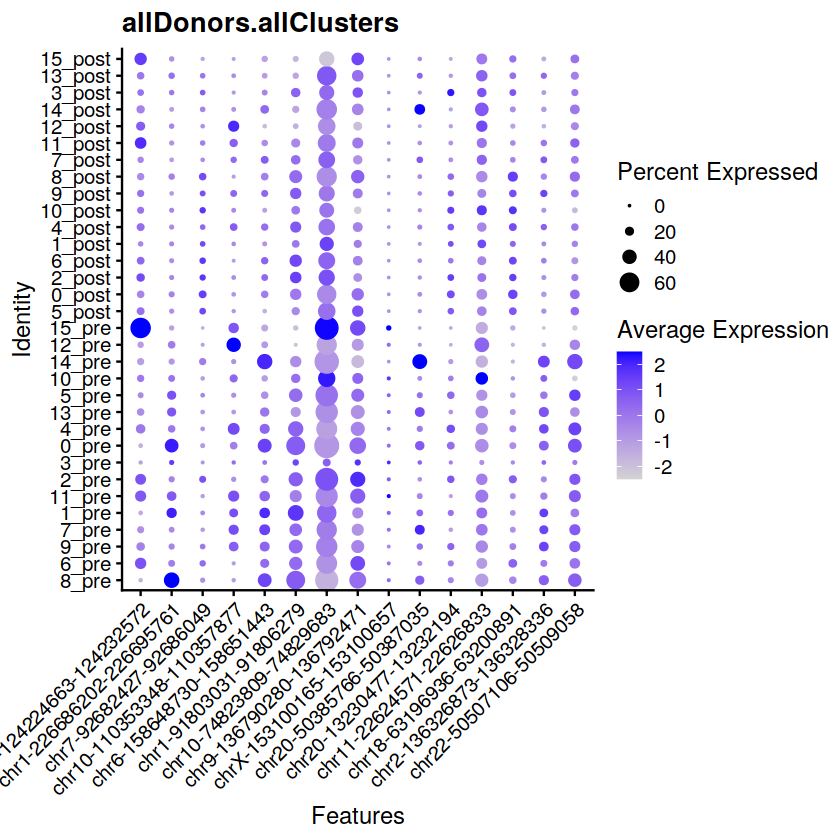

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



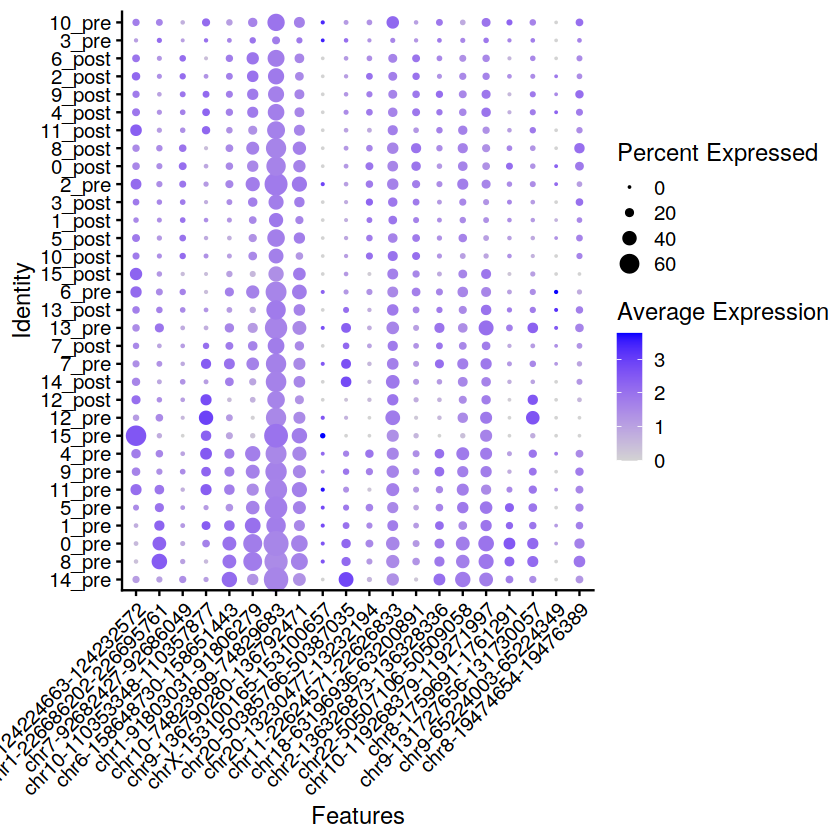

In [8]:
all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, btwnConds_inClust.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=FALSE,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.png"))
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.top3de.pdf"))

## b) averaged top p-values (only average ones that were DE)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



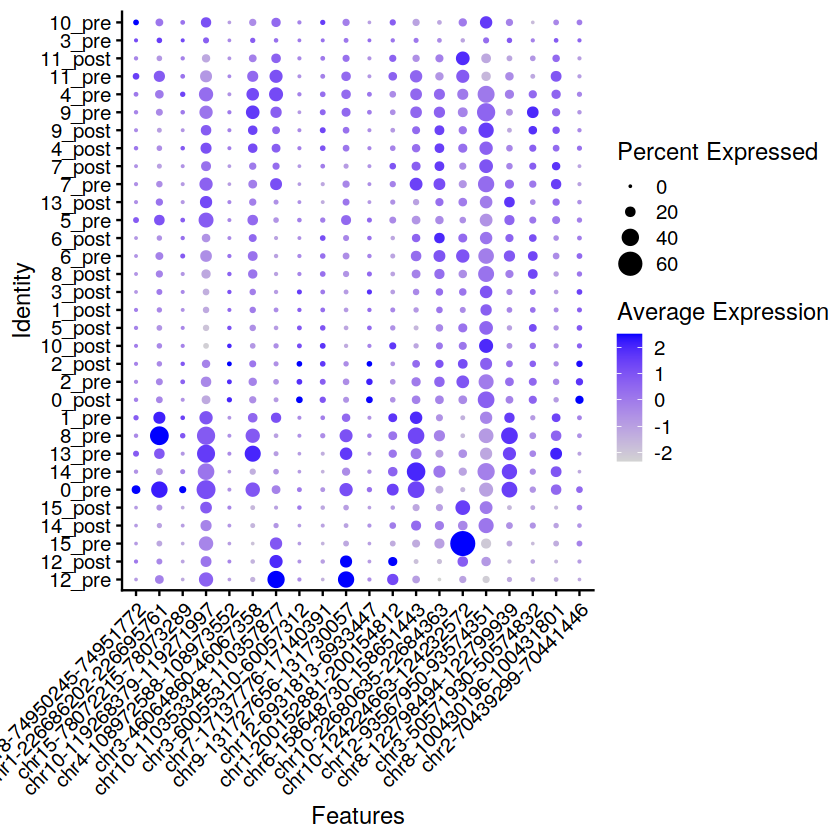

In [9]:
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(btwnConds_inClust.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

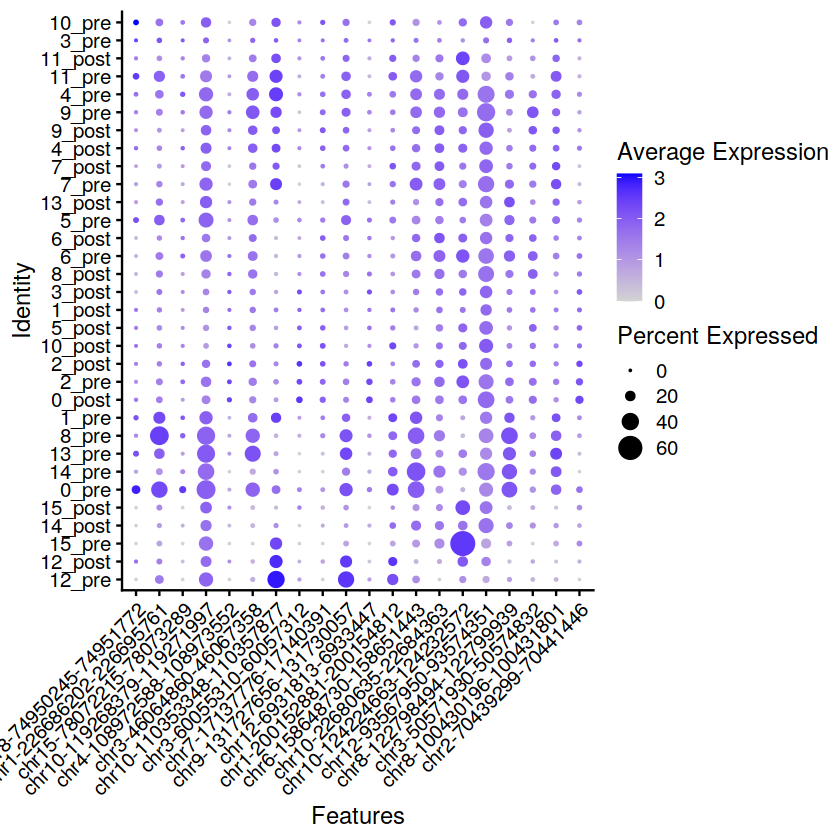

In [10]:
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot


## Each donor separately

In [11]:
se$condition.name <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
se$condition.clust <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters") ] , 1 , paste , collapse = "_" ))

In [12]:
# get clust and donor information
source(utils_script)
clust.ids <- levels(se$seurat_clusters)
don.ids <- levels(se$donor)
#cols <- c("seurat_clusters", "donor")
curr.ids <- levels(as.factor(apply(se[[]][ , c( "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" )))
# Setup Idents to include the condition, clusters and donor
Idents(se) <- as.factor(apply(se[[]][ , c("orig.ident", "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
se$curr.id = Idents(se)

# setup output
# all.pvals is gene-by-comparison df of the pvalue results
all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()

# Loop through clusters and donors and compare between conditions
for (cl in clust.ids){
    if (cl == "None"){
        next
    }
    for (d in don.ids){
        if (d == "None"){
            print('Skipping None')
            next
        }
        c <- paste0(cl, "_", d)
        cl.names.sig = c()
        
        try({
            print("c")
            print(c)
            id1 <- paste(sample_names[[1]], c, sep="_")
            id2 <- paste(sample_names[[2]], c, sep="_")         
            curr.name <- c
            curr.name <- paste(c, sample_names[[1]], sample_names[[2]], sep='_')
            curr.clust.donor.outdir <- file.path(btwnConds_inClust_sepDonrs.outdir,
                                                 paste0("clust_", cl, "donor_", d))
            dir.create(curr.clust.donor.outdir)

            curr.sig <- find.markers.and.plot(se, id1, id2, curr.clust.donor.outdir, 
                                              curr.name=curr.name, assay="ATAC",
                                              latent.var=latent.vars, test.use=test.use,
                                              min.pct=minPct, p.thresh=p_thresh, logfcthresh=logfcthresh)
            if (length(names(curr.sig)) > 0){
                print("adding sig vals to all pvals")
                names.sig <- rownames(curr.sig)
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
            }else{
                print("no sig variables found")
            }
        })
    }
}

[1] "c"
[1] "0_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 96 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 34841     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "0_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1903 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr10-124224663-124232572 2.147472e-19 -0.4671705 0.020 0.139 1.679968e-14
chr10-119268379-119271997 4.123172e-18  0.6548873 0.469 0.138 3.225558e-13
chr1-2

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "1_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 238 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2  p_val_adj
chr7-92423940-92425964   5.051157e-08 -0.3387100     0 0.058 0.00395152
chr4-169410520-169411590 1.282937e-07 -0.2874335     0 0.047 0.01003642
chr19-609950-611954      1.721738e-07 -0.2564200     0 0.047 0.01346916
chr22-49925140-49926474  5.735708e-07 -0.2685917     0 0.047 0.04487044
chr15-76310495-76312125  2.176642e-06 -0.2812461     0 0.047 0.17027870
chr10-62185952-62187948  4.506537e-06 -0.2709070     0 0.035 0.35254640
                         p_val_adj_BH
chr7-92423940-92425964    0.001213136
chr4-169410520-169411590  0.001378366
chr19-609950-611954       0.001378366
chr22-49925140-49926474   0.003443862
chr15-76310495-76312125   0.010455282
chr10-62185952-62187948   0.018038917
[1] "dim response"
[1] 24017     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "1_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1384 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr1-91803031-91806279    2.966371e-16  0.6916129 0.497 0.139 2.320592e-11
chr10-110353348-110357877 6.810426e-15  0.6549084 0.211 0.033 5.327797e-10
chr6-158648730-158651443  5.314097e-14  0.7022654 0.288 0.050 4.157218e-09
chr6-24794881-24803986    2.256091e-12 -0.2006322 0.000 0.033 1.764940e-07
chr2-136326873-136328336  1.224543e-10  0.6005715 0.218 0.043 9.579603e-06
chr2-171318672-171319804  2.414072e-10  0.4723377 0.078 0.003 1.888529e-05
                          p_val_adj_BH
chr1-91803031-91806279    4.086473e-12
chr10-110353348-110357877 4.691022e-11
chr6-158648730-158651443  2.4402

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "2_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1806 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr3-14401878-14403952   2.156105e-06  0.4224675 0.281 0.106 0.1686721
chr7-91084825-91085894   2.528850e-06 -0.1102601 0.017 0.032 0.1978319
chr1-120388740-120389633 5.657949e-06  0.1550678 0.018 0.000 0.4426213
chr17-42111908-42113271  1.077265e-05  0.3659795 0.130 0.036 0.8427445
chr10-74823809-74829683  2.207688e-05  0.2147743 0.719 0.460 1.0000000
chr13-41451782-41453193  4.081703e-05 -0.1123395 0.003 0.016 1.0000000
                         p_val_adj_BH
chr3-14401878-14403952     0.01840876
chr7-91084825-91085894     0.01840876
chr1-120388740-120389633   0.02745802
chr17

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "2_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 105 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 35795     7
[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "3_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 65 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 23328     7
[1] "adding sig vals to

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "4_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1173 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr3-75640916-75641668   1.957377e-06 -0.1678957 0.005 0.025 0.1531256
chr1-206816606-206817639 4.677821e-06  0.3345679 0.095 0.026 0.3659460
chrX-19743126-19743834   1.777309e-05  0.1882311 0.020 0.000 1.0000000
chr13-27353157-27353558  1.938831e-05  0.1989405 0.020 0.000 1.0000000
chr22-50507106-50509058  2.156936e-05  0.4854255 0.340 0.119 1.0000000
chr8-29554962-29556869   2.912050e-05  0.2982665 0.265 0.137 1.0000000
                         p_val_adj_BH
chr3-75640916-75641668     0.03346723
chr1-206816606-206817639   0.03999070
chrX-19743126-19743834     0.07375857
chr13

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "4_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 238 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2   p_val_adj
chr17-59914222-59914704   2.560189e-08 -0.2922454 0.000 0.038 0.002002836
chr2-136326873-136328336  5.089233e-08  0.8590014 0.340 0.045 0.003981307
chr10-122550874-122551899 8.782379e-07 -0.4672217 0.000 0.068 0.068704551
chr10-124224663-124232572 1.630911e-06 -0.7134430 0.019 0.220 0.127586195
chr1-226662357-226664183  3.925552e-06  0.8942466 0.377 0.053 0.307095900
chr22-39310310-39312768   4.116077e-06 -0.3903751 0.000 0.068 0.322000711
                          p_val_adj_BH
chr17-59914222-59914704   0.0006233547
chr2-136326873-136328336  0.0006233547
chr10-122550874-122551899 0.0071713980
chr10-124224663-124232572 0.0099881088
chr1-226662357-226664183  0.0168052567
chr22-39310310-39312768   0.0168052567
[1] "dim response"
[1] 24497     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "5_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 50 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 29398     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "5_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1213 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr10-124224663-124232572 4.974270e-11 -0.5608606 0.018 0.158 3.891372e-06
chr10-119268379-119271997 7.187807e-11  0.7969015 0.416 0.075 5.623021e-06
chr9-131727656-131730057  4.443627e-10  0.7481016 0.247 0.025 3.476250e-05
chr12-52585059-52586923   5.423670e-10  0.8158906 0.355 0.053 4.242937e-05
chr8-1759691-1761291      1.214268e-09  0.8390841 0.271 0.032 9.499221e-05
chr2-105800067-105805015  3.314818e-09  0.7735286 0.325

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "6_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1191 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 17470     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "6_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 59 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 30681     7
[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "7_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 661 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 17020     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "7_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 270 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
       

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "8_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 51 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 27950     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "8_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1157 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                                 p_val avg_log2FC pct.1 pct.2    p_val_adj
chr1-226686202-226695761  8.686355e-14  0.8556933 0.456 0.099 6.795335e-09
chr10-124224663-124232572 8.488487e-13 -0.4409263 0.015 0.126 6.640543e-08
chr3-114212887-114216465  7.756970e-12  0.4457403 0.581 0.260 6.068278e-07
chr2-105800067-105805015  1.109010e-11  0.6967984 0.394 0.108 8.675783e-07
chr1-226662357-226664183  1.796268e-11  0.7001877 0.296 0.057 1.405221e-06
chr2-29009565-29013453    5.911598e-10  0.6037489 0.343

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "9_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 896 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 17476     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "9_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 102 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 32709     7
[1] "adding sig vals t

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 29091     7
[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "11_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 211 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 23623     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "11_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 195 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
     

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "12_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 106 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr17-82871170-82871492  5.773441e-06  -1.347932     0   0.2 0.4516563
chr2-207502796-207503321 5.877031e-06  -1.291147     0   0.2 0.4597601
                         p_val_adj_BH
chr17-82871170-82871492    0.08894005
chr2-207502796-207503321   0.08894005
[1] "dim response"
[1] 30267     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "12_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 109 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
                               p_val avg_log2FC pct.1 pct.2  p_val_adj
chr10-97497453-97499903 4.961495e-07 -0.7561465 0.000  0.25 0.03881377
chr9-35645750-35651756  1.201508e-06 -0.5493942 0.000  0.16 0.09399399
chr6-33409269-33411977  4.620265e-06  1.0810273 1.000  0.20 0.36144329
chr6-30065910-30067805  9.005172e-06  1.0684774 1.000  0.20 0.70447459
chr19-50475907-50477170 1.478251e-05  1.8834393 0.778  0.01 1.00000000
chr1-96720759-96723785  2.632154e-05 -0.9252662 0.000  0.27 1.00000000
                        p_val_adj_BH
chr10-97497453-97499903   0.01428464
chr9-35645750-35651756    0.01729631
chr6-33409269-33411977    0.04434068
chr6-30065910-30067805    0.06481698
chr19-50475907-50477170   0.08512064
chr1-96720759-96723785    0.08996479
[1] "dim response"
[1] 28791     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "13_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 82 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 30109     7
[1] "adding sig vals to all pvals"
[1] "c"
[1] "13_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 138 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 36276     7
[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "14_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 22 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2 p_val_adj
chr18-56637319-56639588  3.904857e-06  1.5853736 0.778 0.000 0.3054769
chr4-139082028-139085764 3.904857e-06 -0.8179411 0.333 0.769 0.3054769
                         p_val_adj_BH
chr18-56637319-56639588    0.05247932
chr4-139082028-139085764   0.05247932
[1] "dim response"
[1] 26879     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "14_1"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 77 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 34221     7
[1] "adding sig vals to all pvals"
[1] "Skipping None"
[1] "c"
[1] "15_0"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 31 samples within 2 assays 
Active assay: ATAC (78230 features, 0 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: integrated_lsi, umap


Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabili

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabili

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 

[1] "curr sig"
                                p_val avg_log2FC pct.1 pct.2    p_val_adj
chr19-12439709-12441674  5.346356e-77 -0.2101239   0.2 0.238 4.182454e-72
chr14-77026922-77029976  7.957747e-30 -0.2023967   0.2 0.238 6.225346e-25
chr1-52054231-52057298   5.353901e-14 -0.2909803   0.2 0.286 4.188356e-09
chr3-150759365-150765136 8.285593e-05 -0.6292407   0.4 0.667 1.000000e+00
chr16-70064674-70066706  8.285593e-05  1.2193928   0.6 0.048 1.000000e+00
chr5-65924179-65928838   8.285593e-05  0.1657580   0.4 0.238 1.000000e+00
                         p_val_adj_BH
chr19-12439709-12441674  1.804342e-72
chr14-77026922-77029976  1.342830e-25
chr1-52054231-52057298   6.022960e-10
chr3-150759365-150765136 1.382954e-02
chr16-70064674-70066706  1.382954e-02
chr5-65924179-65928838   1.382954e-02
[1] "dim response"
[1] 33749     7


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH" "gene.id"     


Saving 6.67 x 6.67 in image



[1] "adding sig vals to all pvals"
[1] "c"
[1] "15_1"
[1] "se filt before"
Error in WhichCells.Seurat(object = x, cells = cells, idents = idents,  : 
  Cannot find the following identities in the object: pre_15_1
[1] "Skipping None"


## Combined DE results

## i. p-values ordered by average -log p-value if they were significant (p<0.1 here)

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



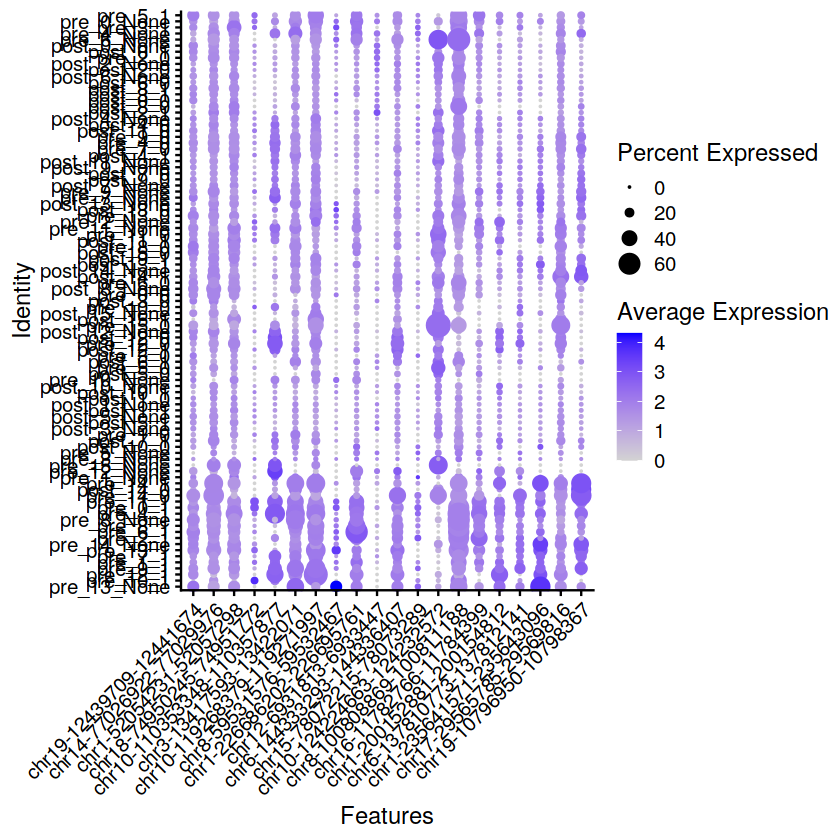

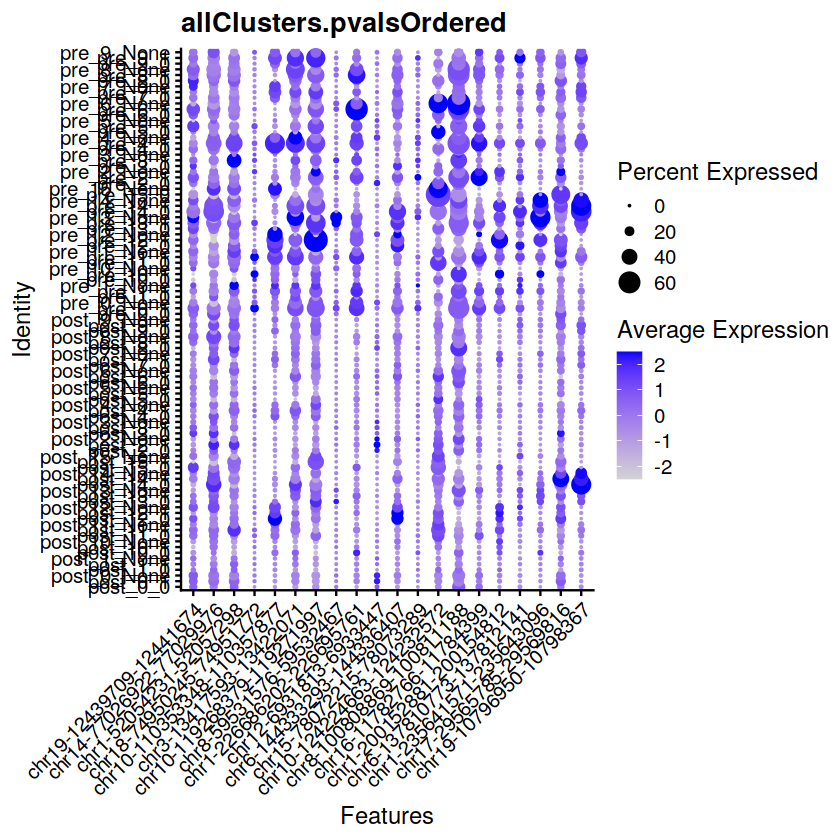

In [13]:
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=FALSE,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot

de.plots(se, names(sig.all.ordered), btwnConds_inClust_sepDonrs.outdir, 
         curr.name="allClusters.pvalsOrdered", max.size=20)

### Same features, but dont separate by donors

Saving 6.67 x 6.67 in image



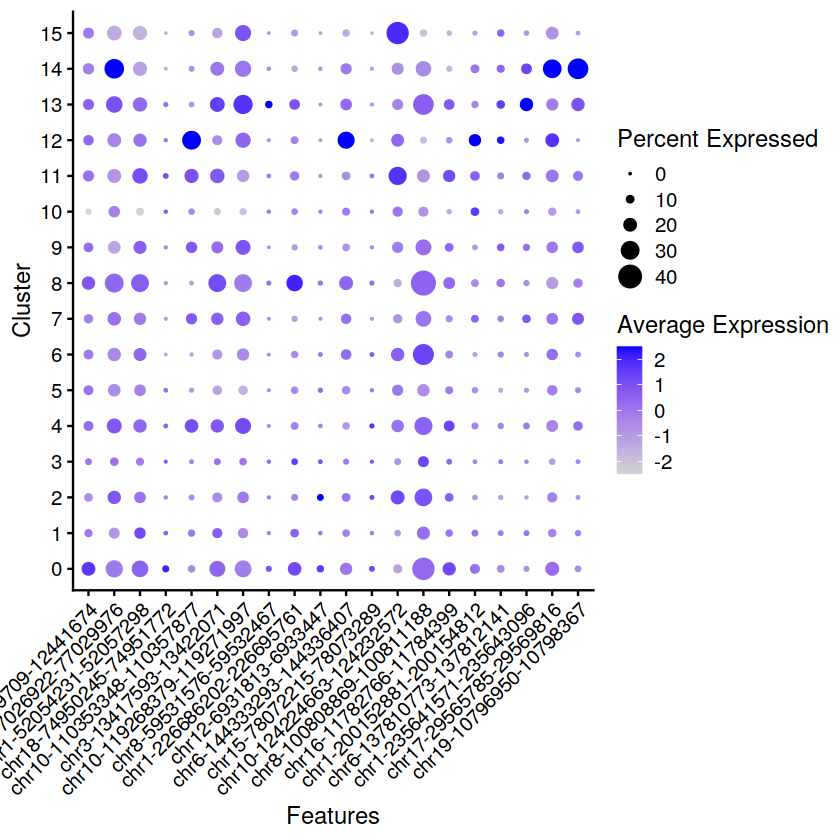

In [14]:
Idents(se)<-se$seurat_clusters
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonorsConds.pvalsOrdered.png"))

dot

,0_0_pre_post,0_1_pre_post,1_0_pre_post,1_1_pre_post,2_0_pre_post,2_1_pre_post,3_0_pre_post,3_1_pre_post,4_0_pre_post,4_1_pre_post,⋯,10_1_pre_post,11_0_pre_post,11_1_pre_post,12_0_pre_post,12_1_pre_post,13_0_pre_post,13_1_pre_post,14_0_pre_post,14_1_pre_post,15_0_pre_post
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1-9944-10547,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-29222-29506,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-191634-191960,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-267850-268201,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-585986-586411,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-605399-605725,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-778170-779495,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-826789-828014,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000
chr1-840668-841028,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0.000000


Saving 6.67 x 6.67 in image



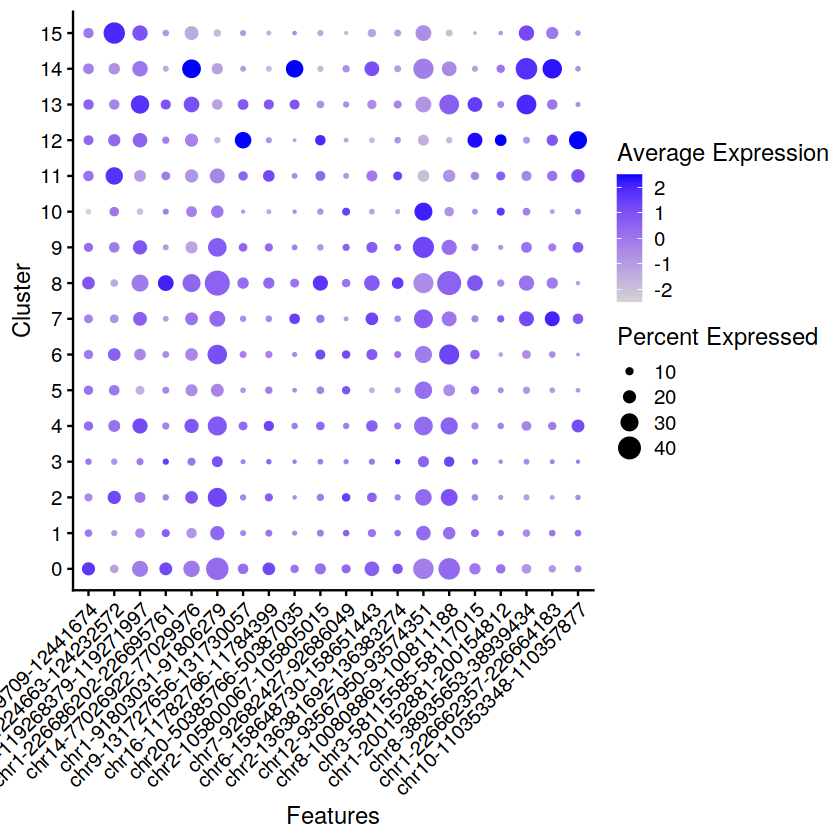

In [15]:
all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))
all.pvals.nafill

Idents(se)<-se$seurat_clusters
sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonorsConds.pvalsOrderedNA.png"))

dot

Saving 6.67 x 6.67 in image



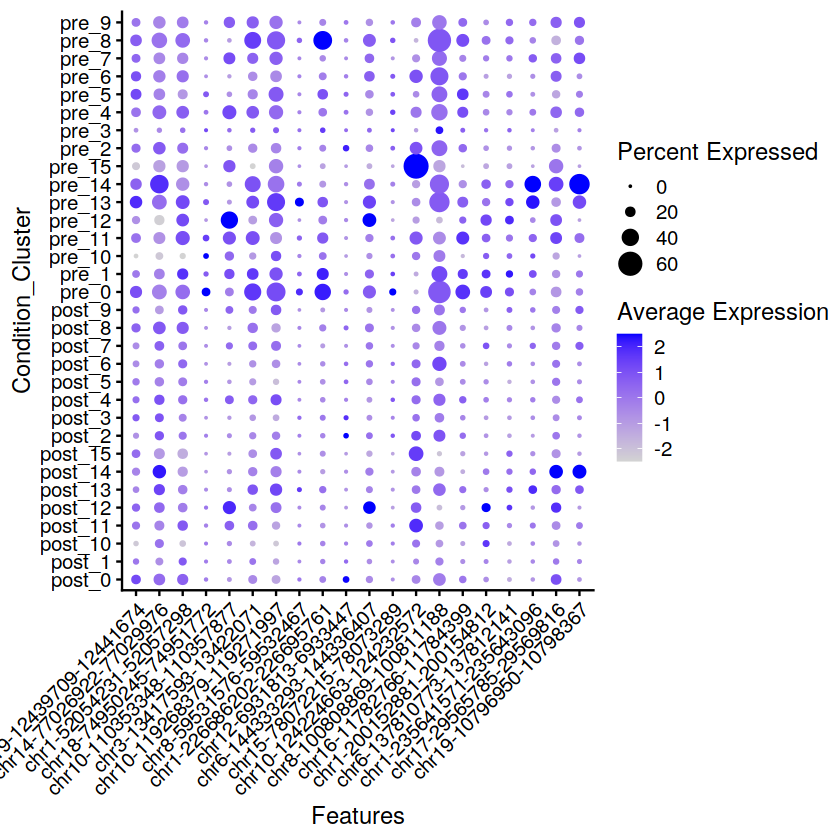

In [16]:
Idents(se)<-se$condition.clust
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Condition_Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.pvalsOrdered.png"))
dot

Saving 6.67 x 6.67 in image



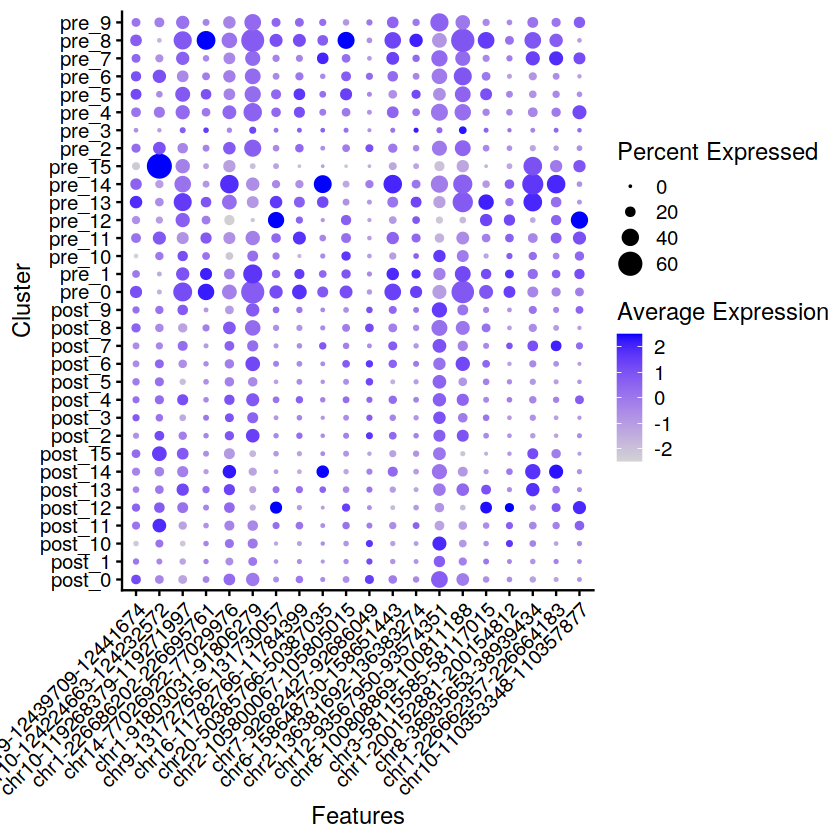

In [17]:
all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

Idents(se)<-se$condition.clust
sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=T,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir,
                 "allClusters.combineDonors.pvalsOrderedNA.png"))

dot

## ii. Taking top 3 of each sig DE

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



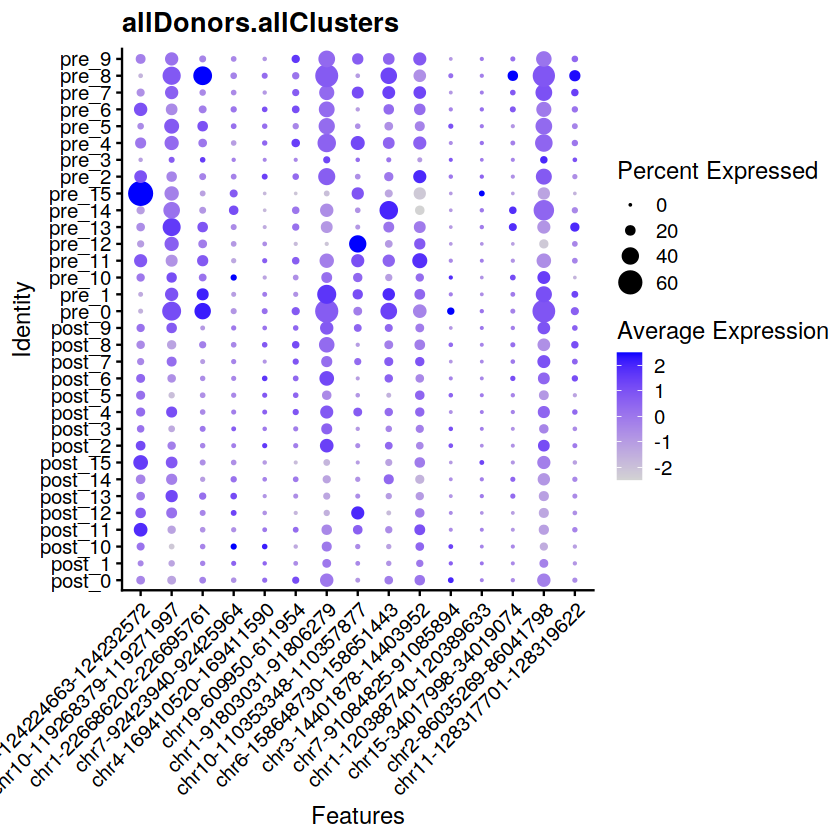

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



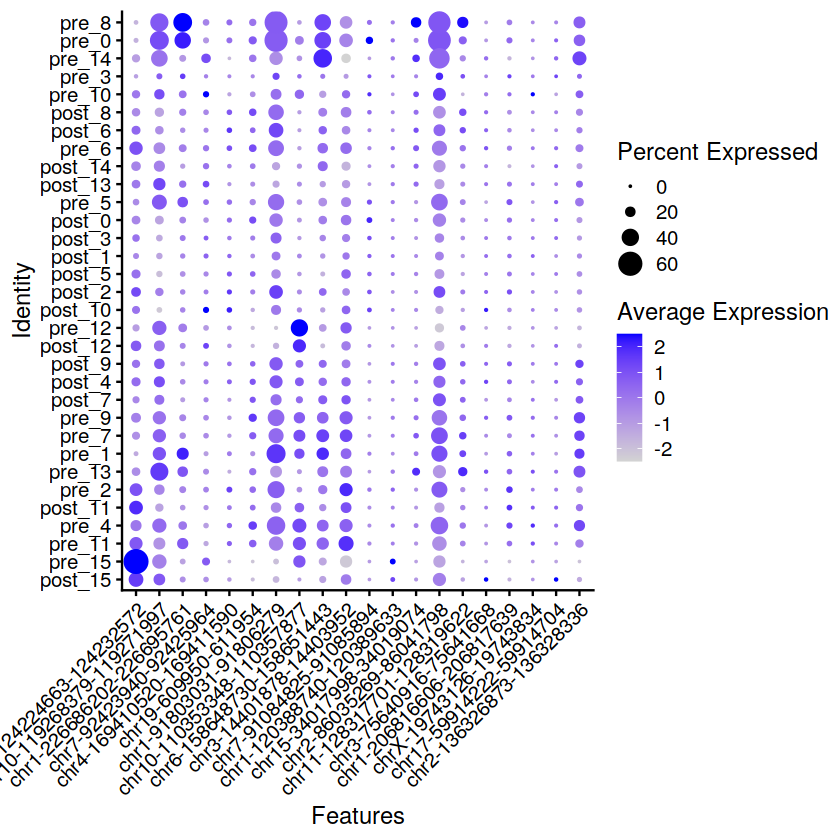

In [18]:
all.names.sig <- unique(all.names.sig)
de.plots(se, all.names.sig, btwnConds_inClust.outdir, curr.name="allDonors.allClusters", max.size=15)

dot <- DotPlot(se, scale=T,
               features = head(all.names.sig,20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.top3de.png"))
ggsave(file.path(btwnConds_inClust_sepDonrs.outdir, "allClusters.combineDonors.top3de.pdf"))

--------

--------

In [19]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [20]:
print

function (x, ...) 
UseMethod("print")
<bytecode: 0x557cd45c93e0>
<environment: namespace:base>